# Dirac Hamiltonian Tests - New

After tinkering around with the 4 band model, I wanted to redo the 8 band one, and just make it practically the same, just with a little extra Zeeman splitting, which is not possible in the 4 band model, since only 2 bands are crossing in the middle.  

This is now the final script and will be reduced to contain only the most necessary things. For example, we drop the mass anisotropy and most "Delta" matrices (originally 5, now 1).  

Also, we need to correct the issue with the Fermi velocity in the optical conductivity calculations.  

This is the picture to go off of:

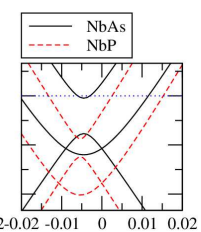  



In [42]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import linalg as LA
#print('numpy=='+np.__version__)

import numba
from numba import njit
from numba.extending import overload, register_jitable
#print('numba=='+numba.__version__)

import matplotlib.pyplot as plt
from ipywidgets import *

def printround(A, precision):
    with np.printoptions(precision=precision, suppress=True):
        print(A)

import warnings
#np.array.vdot = vdot
#for some reason, this gives an error for arrays. 


%load_ext watermark

# python, numba, and machine characteristics
# no spaces between the arguments!
%watermark -v -m -p numpy,numba,matplotlib,watermark

#date
print("  ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

numpy     : 1.20.3
numba     : 0.54.1
matplotlib: 3.4.3
watermark : 2.3.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

  
Last updated: Tue May 24 2022 15:17:46W. Europe Summer Time



In [2]:
hbar=1.054E-34
e=1.602E-19
m0=9.11E-31 #1.0E-13 #
eps0=8.85E-12

M00=np.array([[1, 0],[0, 0]], dtype=np.complex128)
M01=np.array([[0, 1],[0, 0]], dtype=np.complex128)
M10=np.array([[0, 0],[1, 0]], dtype=np.complex128)
M11=np.array([[0, 0],[0, 1]], dtype=np.complex128)

#sigP=np.matrix('0 0; 0 1') #P: projector into the sigma subspace
sig0=np.array([[1, 0],[0, 1]], dtype=np.complex128)
sigx=np.array([[0, 1],[1, 0]], dtype=np.complex128)
sigy=np.array([[0, -1.j],[1.j, 0]], dtype=np.complex128)
sigz=np.array([[1, 0],[0, -1]], dtype=np.complex128)

one4=np.kron(sig0,sig0)

In [3]:
kmin=-np.pi
kmax=np.pi
kstep=(kmax-kmin)/200
karray=np.arange(kmin, kmax, kstep)
kxarray=karray
kyarray=karray
KX,KY=np.meshgrid(kxarray,kyarray)
ax=3.4517*10**(-9)
ay=3.4517*10**(-9)
QX,QY=np.meshgrid(kxarray/ax,kyarray/ay)
qxarray=kxarray/ax
qyarray=kyarray/ax

# Heavy Side

In [4]:
def heaviside_matrix(A, x2):
    #range() does not work in jitted functions...
    J=np.arange(0,len(A),1, dtype=np.int64)
    I=np.arange(0,len(A[0]),1, dtype=np.int64)
    for j in J:
        for i in I:
            if A[j][i] < 0:
                A[j][i]=0.0
            elif A[j][i] > 0:
                A[j][i]=1.0
            else:
                A[j][i]=x2
    return A# whatever needs to be returned by the algorithm

jitted_heaviside_matrix = njit()(heaviside_matrix)

def heaviside_vector(v, x2):
    #range() does not work in jitted functions...
    I=np.arange(0,len(v),1, dtype=np.int64)
    for i in I:
        if v[i] < 0:
            v[i]=1.0
        elif v[i] > 0:
            v[i]=0.0
        else:
            v[i]=x2
    return v# whatever needs to be returned by the algorithm

jitted_heaviside_vector = njit()(heaviside_vector)

# Data Import

In [5]:
#np.savetxt('./IntensitiesByField/NbAs_FeaturesIntensity_'+str(int(B))+'p'+str(int(100*B)-100*int(B))+'.txt', A, fmt='%.5e', delimiter='\t')
#np.loadtxt(dataname, delimiter='\t', unpack=True)
'''
def importfreqs():
    Bmin=0.25
    Bmax=13
    Bstep=0.25
    Barray_features=np.arange(Bmin,Bmax+Bstep,Bstep)
    IntensitiesByField=[]

    for i in range(len(Barray_features)): 
        B=Barray_features[i]
        dataname='./../../MagOptMeas/DigitizingFeatures/IntensitiesByField/NbAs_FeaturesIntensity_'+str(int(B))+'p'+str(int(100*B)-100*int(B))+'.txt'
        importlist=np.loadtxt(dataname, delimiter='\t', unpack=True)
        IntensitiesByField.append(importlist)
    return IntensitiesByField
'''

"\ndef importfreqs():\n    Bmin=0.25\n    Bmax=13\n    Bstep=0.25\n    Barray_features=np.arange(Bmin,Bmax+Bstep,Bstep)\n    IntensitiesByField=[]\n\n    for i in range(len(Barray_features)): \n        B=Barray_features[i]\n        dataname='./../../MagOptMeas/DigitizingFeatures/IntensitiesByField/NbAs_FeaturesIntensity_'+str(int(B))+'p'+str(int(100*B)-100*int(B))+'.txt'\n        importlist=np.loadtxt(dataname, delimiter='\t', unpack=True)\n        IntensitiesByField.append(importlist)\n    return IntensitiesByField\n"

# Parameters

In [6]:
def setparam(mgap, v, D, s000, s0z0, s0zx, s0zz):
    
    #v=vt
    #D=D4
    
    D=D*e/1000
    
    s000=s000*e/1000
    s0z0=s0z0*e/1000
    s0zx=s0zx*e/1000
    s0zz=s0zz*e/1000
    
    mgap=mgap*e/1000
    
    alphax=np.kron(sigx, sigx)
    alphay=np.kron(sigx, sigy)
    alphaz=np.kron(sigx, sigz)
    beta=  np.kron(sigz, sig0)
    matrix=np.kron(sigz, sigz)
    
    #Matrices with only one entry=1, rest 0
    tl=0.5*(sig0+sigz) #top left
    br=0.5*(sig0-sigz) #bottom right
    tr=0.5*(sigx+1.j*sigy) #top right
    bl=0.5*(sigx-1.j*sigy) #bottom left
    
    
    help1=( np.kron(tr,np.kron(bl,bl))  +np.kron(bl,np.kron(tr,tr)))
    help2=( np.kron(tr,np.kron(bl,tr))  +np.kron(bl,np.kron(tr,bl)))
    DELTA=D*(help1+help2)
    
    One4=np.eye(4, dtype=np.complex128)
    One2=np.eye(2, dtype=np.complex128)
    
    AX=np.kron(One2, alphax*v)
    AY=np.kron(One2, alphay*v)
    BETA=np.kron(One2, beta*mgap)
    
    S000=np.kron(sig0,np.kron(sig0, sig0))*s000 #Spin, Velocity
    S0Z0=np.kron(sig0,np.kron(sigz, sig0))*s0z0 #"Spin" should just signify that this acts within the 2x2 blocks
    S0ZX=np.kron(sig0,np.kron(sigz, sigx))*s0zx #Spin, Mass
    S0ZZ=np.kron(sig0,np.kron(sigz, sigz))*s0zz
    
    
    return AX, AY, BETA, DELTA, S000,  S0Z0 , S0ZX , S0ZZ
    #return AX_T, AY_T, BETA_T, V1X_T, V1Y_T, MATRIX, DELTA1, DELTA2, DELTA3, DELTA4, DELTA5

jitted_setparam = njit()(setparam)

In [13]:
def E_Model_1DCut(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, qxarray):
    hbar=1.054E-34
    e=1.602E-19
    m0=9.11E-31 
    eps0=8.85E-12
    theta=theta * np.pi / 180.
    
    #The scaling parameters v, D, ... are used in setparam() and scale the matrices AX, AY, ...
    AX, AY, BETA, DELTA, S000,  S0Z0 , S0ZX , S0ZZ=setparam(mgap, v, D, s000, s0z0, s0zx, s0zz)
    
    t=(2*hbar*e)**0.5
    lenqx=len(qxarray)
    E_Model_1DCut=np.zeros((lenqx, 8), dtype=np.complex128)
    
    for iqx in range(lenqx):
        qx=qxarray[iqx]
        H_Model_1DCut=hbar*qx*AX*np.cos(theta) + hbar*qx*AY*np.sin(theta) + BETA + DELTA + S000 + S0Z0 + S0ZX + S0ZZ
        E_Model_1DCut[iqx]=LA.eigh(H_Model_1DCut)[0]/e*1000
    return E_Model_1DCut

interactive(children=(FloatSlider(value=40.0, description='mgap', min=-100.0, step=1.0), FloatLogSlider(value=…

<function __main__.update(mgap, v, D, s000, s0z0, s0zx, s0zz, theta)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
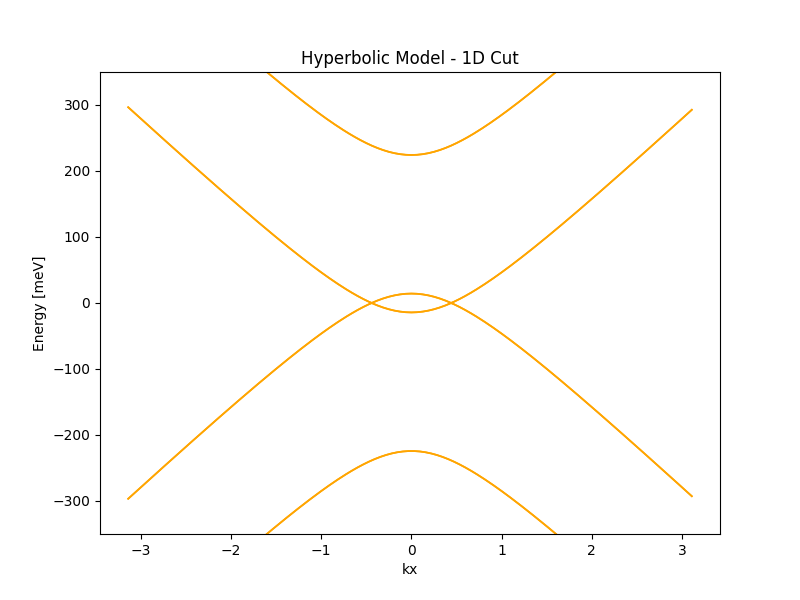

In [14]:
Bnumber=100
Bstart=0.01
Bmax=13
Bstep=(Bmax-Bstart)/Bnumber
Barray=np.arange(Bstart,Bmax,Bstep)


fig_Model_1DCut, (ax_Model_1DCut) = plt.subplots(figsize=(8, 6))
ax_Model_1DCut.set_xlim([-np.pi, np.pi])
warnings.filterwarnings("ignore")

dim=8

def update(mgap, v, D, s000, s0z0, s0zx, s0zz, theta):
    #The following prints are for the use of copy and pasting parameters of interest, while testing around
    print('mgap='+str(mgap))
    print('v='+str(v))
    print('D='+str(D))
    print('s000='+str(s000))
    print('s0z0='+str(s0z0))
    print('s0zx='+str(s0zx))
    print('s0zz='+str(s0zz))
    print('theta='+str(theta))
    
    Lines_Model_1DCut=[]
    
    ax_Model_1DCut.clear()
    ax_Model_1DCut.set_title('Hyperbolic Model - 1D Cut')
    ax_Model_1DCut.set_xlabel('kx')
    ax_Model_1DCut.set_ylabel('Energy [meV]')
    ax_Model_1DCut.set_ylim([-350, 350])
    #EF=0 #Uncomment these lines, if a horizontal Fermi level line at value EF [meV] should be drawn for orientation
    #ax_Model_1DCut.hlines(y=EF, xmin=qxarray[0]*ax, xmax=qxarray[-1]*ax, linewidth=2, color='r')
    #------------------------------------------------------------------
    for i in range(dim):
        line_Model_1DCut, = ax_Model_1DCut.plot(qxarray*ax, qxarray*0, lw=1.25, color='orange')
        Lines_Model_1DCut.append(line_Model_1DCut)
    
    Energies_Model_1DCut=E_Model_1DCut(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, qxarray).T
    #print(Energies_4DDirac.T[0])
    
    for i in range(dim):
        Lines_Model_1DCut[i].set_ydata(Energies_Model_1DCut[i].real)
    #------------------------------------------------------------------
    
    fig_Model_1DCut.canvas.draw_idle()
    


mgap=40.0
v=672010.8393559097
D=0.0
s000=0.0
s0z0=65.0
s0zx=-100.0
s0zz=65.0
theta=90.0

interact(update, mgap=widgets.FloatSlider(value=mgap,min=-100,max=100,step=1), \
         v=widgets.FloatLogSlider(value=v,base=10,min=4,max=7,step=0.01), \
         D=widgets.FloatSlider(value=D,min=-100,max=100,step=1), \
         s000=widgets.FloatSlider(value=s000,min=-200,max=200,step=1), \
         s0z0=widgets.FloatSlider(value=s0z0,min=-200,max=200,step=1), \
         s0zx=widgets.FloatSlider(value=s0zx,min=-200,max=200,step=1), \
         s0zz=widgets.FloatSlider(value=s0zz,min=-200,max=200,step=1), \
         theta=widgets.FloatSlider(value=theta,min=0,max=360,step=1))


#theta lets you tune from between kx (theta=0) and ky (theta=90)

# 2D Plot 8-Band

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
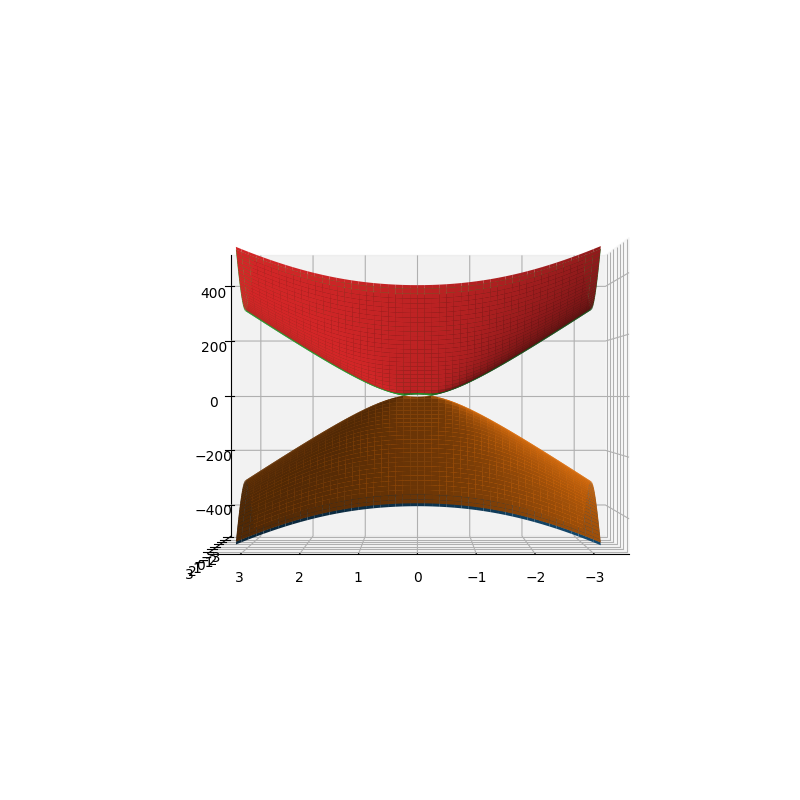

In [15]:
dim=8
E_Model_2DCut=np.zeros((dim, len(kxarray), len(kyarray)), dtype=np.complex128)

mgap=50.0
v=672010.8393559097
D=10.0
s000=0.0
s0z0=65.0
s0zx=-100.0
s0zz=65.0
theta=177.0

#The scaling parameters v, D, ... are used in setparam() and scale the matrices AX, AY, ...
AX, AY, BETA, DELTA, S000,  S0Z0 , S0ZX , S0ZZ=setparam(mgap, v, D, s000, s0z0, s0zx, s0zz)

for iqy in range(len(qyarray)):
    qy=qyarray[iqy]
    for iqx in range(len(qxarray)):
        qx=qxarray[iqx]
        H_Model_2DCut=hbar*qx*AX + hbar*qy*AY + BETA + DELTA + S000 + S0Z0 + S0ZX + S0ZZ
        
        eigenValues=LA.eigh(H_Model_2DCut)[0]
        for iE in range(len(E_Model_2DCut)):
            E_Model_2DCut[iE][iqx][iqy]= eigenValues[iE].real
E_Model_2DCut=E_Model_2DCut/e*1000
fig_Model_2DCut, ax_Model_2DCut = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,8))
ax_Model_2DCut.view_init(azim=90, elev=0)

#Plot only the middle 4 bands
bands_plot=[2,3,4,5]
for iE in bands_plot:
    ax_Model_2DCut.plot_surface(KX, KY, E_Model_2DCut.real[iE])

# Landau Levels

In [16]:
def LLs(mgap, v, D, s000, s0z0, s0zx, s0zz, N, Barray):
    #M00= np.array([[ 1 , 0 ], [ 0 , 0 ]], np.complex128)
    
    hbar=1.054E-34
    e=1.602E-19
    m0=9.11E-31 #1.0E-13 #
    eps0=8.85E-12
    
    AX, AY, BETA, DELTA, S000,  S0Z0 , S0ZX , S0ZZ=setparam(mgap, v, D, s000, s0z0, s0zx, s0zz)
    
    H_LLs=np.zeros((8*N,8*N))
    PQ=np.zeros((8*N,8*N))
    
    
    OneN=np.eye(N)
    
    lenB=len(Barray)
    E_LLs=np.zeros(shape=(lenB,8*N))
    
    iB=0 
    
    a_diag=np.arange(1,N,1)
    a=np.diag(a_diag**0.5,k=1)
    ad=np.diag(a_diag**0.5,k=-1)
    
    
    px=np.zeros((N,N), dtype=np.complex128)
    py=np.zeros((N,N), dtype=np.complex128)
    
    px=0.5*(a+ad)
    py=0.5j*(ad-a)
    
    
    ql=0
    Plx_LL=np.kron(AX,np.ascontiguousarray((px+0.j)))#*clx
    Ply_LL=np.kron(AY,np.ascontiguousarray((py+0.j)))
    
    #Do I have to change the gaps? they should not contain zeros at beginning and end, should they?
    #Otherwise there will always be ungapped states
    BETA_N=np.kron(BETA, OneN)
    DELTA_N=np.kron(DELTA, OneN)
    S000_N= np.kron(S000, OneN)
    S0Z0_N= np.kron(S0Z0, OneN)
    S0ZX_N= np.kron(S0ZX, OneN)
    S0ZZ_N= np.kron(S0ZZ, OneN)
    
    
    for B in Barray:
        H_LLs=(hbar*e*B)**0.5*(Plx_LL + Ply_LL)+BETA_N+DELTA_N + S000_N + S0Z0_N + S0ZX_N + S0ZZ_N
        eigenValues=LA.eigh(H_LLs)[0]
        E_LLs[iB]= eigenValues.real
        iB+=1
    
    return E_LLs/e*1000


interactive(children=(FloatSlider(value=49.0, description='mgap', min=-100.0, step=1.0), FloatLogSlider(value=…

<function __main__.update(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, N)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
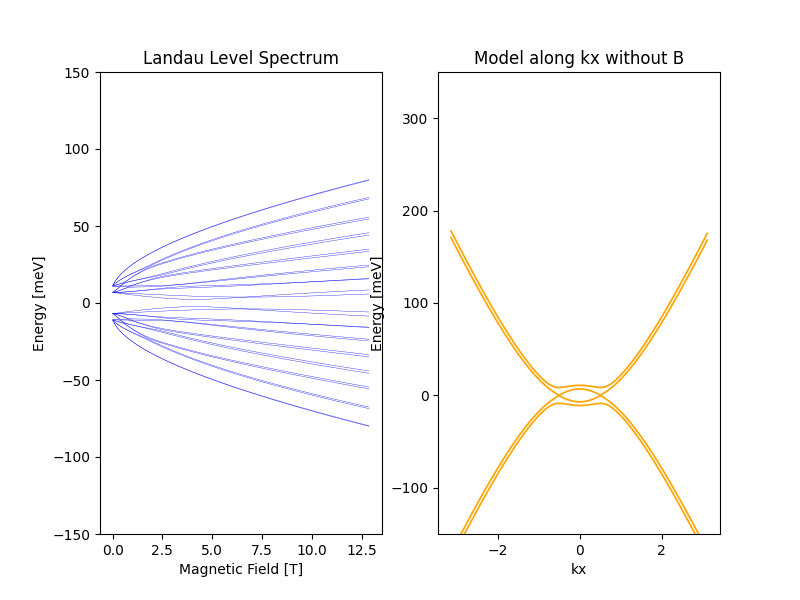

In [23]:
Bnumber=100
Bstart=0.01
Bmax=13
Bstep=(Bmax-Bstart)/Bnumber
Barray=np.arange(Bstart,Bmax,Bstep)

N=8

fig_LLs, (ax_LLs, ax_Model_1DCut_2) = plt.subplots(1,2,figsize=(8, 6))
ax_LLs.set_xlim([0, Bmax])
#ax_LLs.set_ylim([-5, 5])
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
theta=0

def update(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, N):
    print('mgap='+str(mgap))
    print('v='+str(v))
    print('D='+str(D))
    print('s000='+str(s000))
    print('s0z0='+str(s0z0))
    print('s0zx='+str(s0zx))
    print('s0zz='+str(s0zz))
    print('theta='+str(theta))
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    dim_LLs=8*N
    Lines_LLs=[]
    dim=8
    Lines_Model_1DCut_2=[]
    ax_LLs.clear()
    ax_LLs.set_title('Landau Level Spectrum')
    ax_LLs.set_xlabel('Magnetic Field [T]')
    ax_LLs.set_ylabel('Energy [meV]')
    ax_LLs.set_ylim([-150, 150])
    #ax_LLs.hlines(y=EF, xmin=Bstart, xmax=Bmax, linewidth=2, color='r')
    
    ax_Model_1DCut_2.clear()
    ax_Model_1DCut_2.set_title('Model along kx without B')
    ax_Model_1DCut_2.set_xlabel('kx')
    ax_Model_1DCut_2.set_ylabel('Energy [meV]')
    ax_Model_1DCut_2.set_ylim([-150, 350])
    #EF=0 #Uncomment for plotting horizontal Fermi level
    #ax_qx.hlines(y=EF, xmin=qxarray[0]*ax, xmax=qxarray[-1]*ax, linewidth=2, color='r')
    
    Barray=np.arange(Bstart,Bmax,Bstep)
    
    #------------------------------------------------------------------
    for i in range(dim_LLs):
        line_LLs, = ax_LLs.plot(Barray, Barray*0, lw=0.25, color='blue')
        Lines_LLs.append(line_LLs)
    E_LLs=LLs(mgap, v, D, s000, s0z0, s0zx, s0zz, N, Barray).T
    for i in range(dim_LLs):
        Lines_LLs[i].set_ydata(E_LLs[i].real)
    #------------------------------------------------------------------
    
    
    #------------------------------------------------------------------
    for i in range(dim):
        line_Model_1DCut_2, = ax_Model_1DCut_2.plot(qxarray*ax, qxarray*0, lw=1.25, color='orange')
        Lines_Model_1DCut_2.append(line_Model_1DCut_2)
    
    Energies_Model_1DCut_2=E_Model_1DCut(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, qxarray).T
    
    for i in range(dim):
        Lines_Model_1DCut_2[i].set_ydata(Energies_Model_1DCut_2[i].real)
    #------------------------------------------------------------------
    
    fig_LLs.canvas.draw_idle()
    

mgap=49.0
v=522010.8393559097
D=12.0
s000=0.0
s0z0=130.0
s0zx=-133.0
s0zz=130.0
theta=90.0

interact(update, mgap=widgets.FloatSlider(value=mgap,min=-100,max=100,step=1), \
         v=widgets.FloatLogSlider(value=v,base=10,min=4,max=7,step=0.01), \
         D=widgets.FloatSlider(value=D,min=-100,max=100,step=1), \
         s000=widgets.FloatSlider(value=s000,min=-200,max=200,step=1), \
         s0z0=widgets.FloatSlider(value=s0z0,min=-200,max=200,step=1), \
         s0zx=widgets.FloatSlider(value=s0zx,min=-200,max=200,step=1), \
         s0zz=widgets.FloatSlider(value=s0zz,min=-200,max=200,step=1), \
         theta=widgets.FloatSlider(value=theta,min=0,max=360,step=1), \
         N=widgets.IntSlider(value=8,min=4,max=20,step=1))

# Magneto Optics 8 Band

In [35]:
#SO, IN MATLAB .* IS ELEMENT WISE MULTIPLICATION OF MATRICES AND CORRESPONDS TO JUST * IN PYTHON
#BUT * IS AN ACTUAL MATRIX PRODUCT AND CORRESPONDS TO @ IN PYTHON
#JEEZUS!
    

def optic_LLs(mgap, v, D, s000, s0z0, s0zx, s0zz, EF, gamma, N, Barray, e_probe):
    #M00= np.array([[ 1 , 0 ], [ 0 , 0 ]], np.complex128)
    
    dim=8
    
    hbar=1.054E-34
    e=1.602E-19
    m0=9.11E-31 #1.0E-13 #
    eps0=8.85E-12  
    
    #m=c_m*m0
    
    AX, AY, BETA, DELTA, S000,  S0Z0 , S0ZX , S0ZZ=jitted_setparam(mgap, v, D, s000, s0z0, s0zx, s0zz)
    
    EF=EF #meV
    
    OnesDimN=np.ones((dim*N,dim*N)) #matrix of ones (all elements)
    onesDimN=np.ones(dim*N) #array of ones
    onesN=np.ones(N) #array of ones

    
    lenB=Barray.size#len(Barray)
    lenE=e_probe.size#len(e_probe)
    
    E_LLs=np.zeros(shape=(lenB,dim*N), dtype=np.complex128)
    v_LLs=np.zeros(shape=(dim*N,dim*N), dtype=np.complex128)
    sigma_p=np.zeros(shape=(lenE,lenB), dtype=np.complex128)
    sigma_m=np.zeros(shape=(lenE,lenB), dtype=np.complex128)
    IntDoS=np.zeros(shape=(dim*N,dim*N), dtype=np.complex128)
    Inverse_Inter_LL=np.zeros(shape=(dim*N,dim*N), dtype=np.complex128)
    
    nE=0
    iB=0
    iB_everyn_save=0
    
    J=np.arange(0,dim*N,1, dtype=np.int64)
    I=np.arange(0,dim*N,1, dtype=np.int64)
    
    
    H_LLs=np.zeros((dim*N,dim*N), dtype=np.complex128)
    
    velocity_p=np.zeros(shape=(dim*N,dim*N), dtype=np.complex128)
    velocity_m=np.zeros(shape=(dim*N,dim*N), dtype=np.complex128)
    
    OneDim=np.eye(dim, dtype=np.complex128)
    
    OneN=np.eye(N, dtype=np.complex128)
    
    a_diag=np.arange(1,N,1)
    a_diag=np.arange(0,N,1)
    a=np.diag(a_diag**0.5,k=1)
    ad=np.diag(a_diag**0.5,k=-1)
    
    a_diag_p=np.arange(0,N+1,1)
    a_diag_p=np.arange(1,N+1,1)
    a_diag_p=np.arange(1,N,1)
    a_p=np.diag(a_diag_p**0.5,k=1)
    ad_p=np.diag(a_diag_p**0.5,k=-1)
    
    
    #Note that the B-dependent factor has to be included in the Hamiltonian
    #For each power of p, one power of (hbar*e*B)**0.5
    
    px=0.5*(a_p+ad_p)#*(hbar*e*B)**0.5
    py=0.5j*(ad_p-a_p)#*(hbar*e*B)**0.5
    ql=0

    Plx_LL=np.kron(AX,np.ascontiguousarray((px+0.j)[ql:N+1+ql,ql:N+1+ql]))#*clx
    Ply_LL=np.kron(AY,np.ascontiguousarray((py+0.j)[ql:N+1+ql,ql:N+1+ql]))#N+1 needed if nothing should be cut off
    
    #Do I have to change the gaps? they should not contain zeros at beginning and end, should they?
    #Otherwise there will always be ungapped states
    BETA_N=np.kron(BETA, OneN)
    DELTA_N=np.kron(DELTA, OneN)
    S000_N= np.kron(S000, OneN)
    S0Z0_N= np.kron(S0Z0, OneN)
    S0ZX_N= np.kron(S0ZX, OneN)
    S0ZZ_N= np.kron(S0ZZ, OneN)
    
    Vlx_LL=np.kron(AX,OneN)
    Vly_LL=np.kron(AY,OneN)
    
     
    vf=1e5 #why can i just choose a vf?! shouldnt i determine it from position of fermi level and energy of bands? 
    
    
    for B in Barray:
        
        H_LLs=(hbar*e*B)**0.5*(Plx_LL + Ply_LL)+BETA_N+DELTA_N + S000_N + S0Z0_N + S0ZX_N + S0ZZ_N
            
        e_LLs, v_LLs=LA.eigh(H_LLs)
        e_LLs=e_LLs/e*1000 #meV
        
        diag_spkt_ones=(e_LLs*OnesDimN).T
        Inter_LL=diag_spkt_ones-diag_spkt_ones.T.conjugate()
        Inverse_Inter_LL=1./Inter_LL
        
        for j in J:
            for i in I:
                if np.isinf(Inverse_Inter_LL[j][i])==True:
                    Inverse_Inter_LL[j][i]=0.0
        IntDoS=(gamma*np.absolute((diag_spkt_ones * (diag_spkt_ones.T.conjugate()))*Inverse_Inter_LL))**0.5*e/(2000*np.pi*hbar*vf)
        Occupation=((jitted_heaviside_vector(e_LLs-EF*onesDimN,0.5)*OnesDimN)) * ((jitted_heaviside_vector(EF*onesDimN - e_LLs,0.5)*OnesDimN)).T
        
        v_x= Vlx_LL
        v_y= Vly_LL
        
        velocity_p=v_x+1.j*v_y
        velocity_m=v_x-1.j*v_y
        
        v_pmatrix=  np.absolute(v_LLs.T.conjugate()@velocity_p@v_LLs)**2
        v_mmatrix=  np.absolute(v_LLs.T.conjugate()@velocity_m@v_LLs)**2
        
        
        IE=np.arange(0,len(e_probe),1, dtype=np.int64)
        for iE in IE:
            sigma_p[iE,iB]=1.j*10**6*e/(2*np.pi)*B*np.sum(np.sum(v_pmatrix * Occupation * IntDoS/2./(e_probe[iE]-Inter_LL+1.j*gamma) * Inverse_Inter_LL, axis=0, dtype=np.complex128), axis=0, dtype=np.complex128)
            sigma_m[iE,iB]=1.j*10**6*e/(2*np.pi)*B*np.sum(np.sum(v_mmatrix * Occupation * IntDoS/2./(e_probe[iE]-Inter_LL+1.j*gamma) * Inverse_Inter_LL, axis=0, dtype=np.complex128), axis=0, dtype=np.complex128)
            #the inner sum sums the vectors in the matrix. yields a vector. axis=0 sums downward.
            #the outer sum sums the vector elements together. yields a scalar.
        
        E_LLs[iB]= e_LLs 
        iB+=1
        everyn=30
        if int(iB/everyn)-iB_everyn_save>0: 
            print(iB)
        
        iB_everyn_save=int(iB/everyn) 
    print('I AM DONE!')
    return sigma_p, sigma_m, E_LLs
    
jitted_optic_LLs = njit()(optic_LLs)



In [49]:
Bnumber=100 #Density B axis
Bstart=0.01
Bmax=13
Bstep=(Bmax-Bstart)/Bnumber
Barray=np.arange(Bstart,Bmax,Bstep)
print(len(Barray))
lenB=len(Barray)


Bmin_f=0.25
Bmax_f=13
Bstep_f=0.25
Barray_features=np.arange(Bmin_f,Bmax_f+Bstep_f,Bstep_f)
warnings.filterwarnings("ignore")
IntensitiesByField= importfreqs()
warnings.filterwarnings("default")



Enumber=400 #Density E axis
Estart=1 
Emax=325
Emax=150
Estep=(Emax-Estart)/Enumber
e_probe=np.arange(Estart,Emax,Estep)
#print(len(e_probe))
lenE=len(e_probe)


mgap=0.0
vt=391830.9709189362
D=0
s000=0.0
s0z0=20.0
s0zx=0.0
s0zz=-10.0

EF=15
N=14 
gamma = 1  #broadening paremeter in meV

sigma_p, sigma_m, E_LLs = jitted_optic_LLs(mgap, v, D, s000, s0z0, s0zx, s0zz, EF, gamma, N, Barray, e_probe)

100
test
30
60
90
I AM DONE!


(400, 100)


C:\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
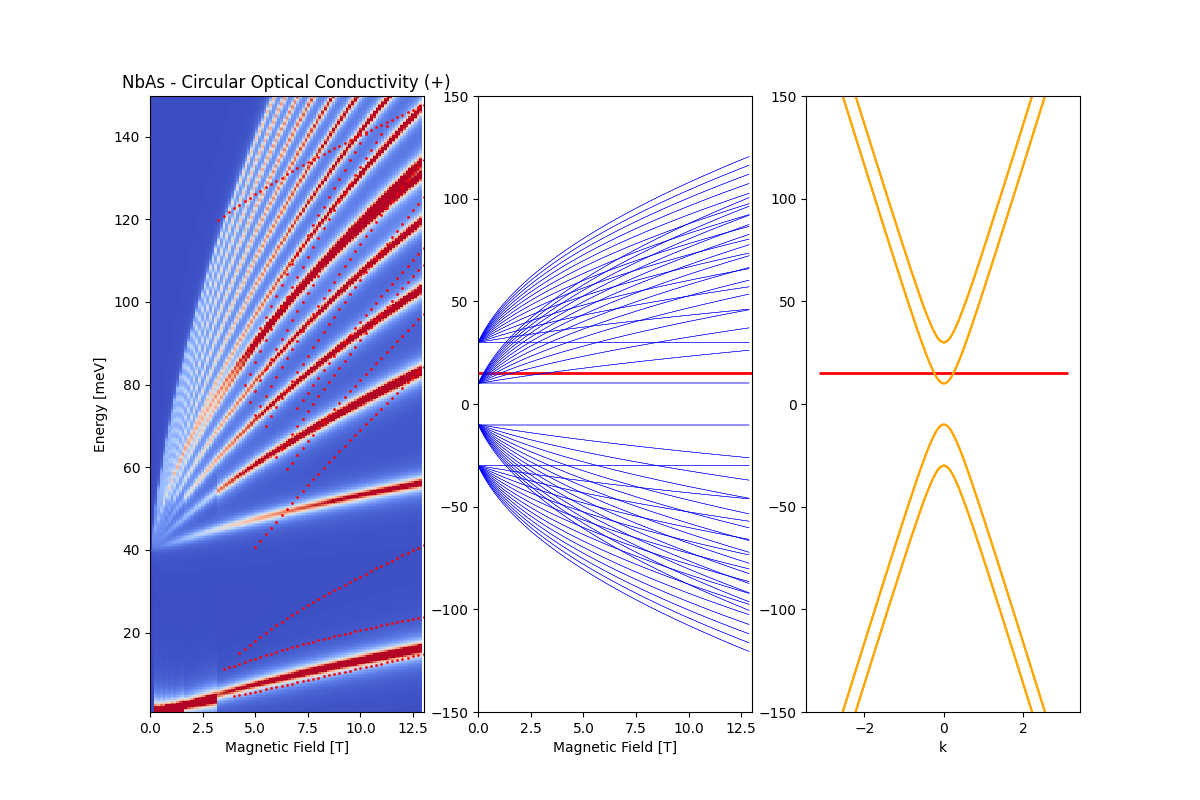

In [50]:
fig_MagOp, (ax_MagOp, ax_LLs, ax_Model_1DCut_3) = plt.subplots(1, 3, figsize=(12,8))
#plt.tight_layout()

dim_LLs=8*N
ax_LLs.set_ylim([-150,150])
ax_LLs.hlines(y=EF, xmin=Bstart, xmax=Bmax, linewidth=2, color='r')
ax_LLs.set_xlabel('Magnetic Field [T]')
ax_LLs.set_xlim([0,13])
for i in range(dim_LLs_8band):
    ax_LLs.plot(Barray, E_LLs.real.T[i], lw=0.35, color='blue')

Energies_Model_1DCut_3=E_Model_1DCut(mgap, v, D, s000, s0z0, s0zx, s0zz, theta, qxarray).T
ax_Model_1DCut_3.set_ylim([-150,150])
ax_Model_1DCut_3.hlines(y=EF, xmin=kxarray[0], xmax=kxarray[-1], linewidth=2, color='r')
ax_Model_1DCut_3.set_xlabel('k')

for i in range(len(Energies_1D)):
    ax_model_8band.plot(kxarray, Energies_1D[i].real, color='orange')
    
BB,EE = np.meshgrid(Barray,e_probe)
BB,EEcm = np.meshgrid(Barray,e_probe*8.)
print(sigma_p.shape)

ax_MagOp.set_title('NbAs - Circular Optical Conductivity (+)')
ax_MagOp.set_xlabel('Magnetic Field [T]')
ax_MagOp.set_ylabel('Energy [meV]')
ax_MagOp.set_xlim([0,13])
surf = ax_MagOp.pcolormesh(BB, EE, sigma_m.real + sigma_p.real, shading='auto', cmap=cm.coolwarm, vmin=-0, vmax=1.0e4)

'''
skip=0
sf=4 #skipfactor, for sf=2 it just plots every half field, meaning 0.5T steps. For 4 it plots every 0.25T.
for i in range(len(Barray_features)): 
    B=Barray_features[i]
    if (sf*B-int(B*sf+0.1))<0.1:
        if np.array(IntensitiesByField[i]).size>0: #this for some reason checks whether list is empty
            
            ax_surf_8band.plot(B+0*IntensitiesByField[i][0],IntensitiesByField[i][0]/8.066,'o', markersize=1, c='r')
            skip+=1
            #to see that the extracted data is in fact smooth, take out the intensities, just leave the offset:
            #ax_extr.plot(IntensitiesByField[i][0],1+0*IntensitiesByField[i][1]+offset*i+markeroffset,'v', markersize=2, c='b')
'''

plt.show()